In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.4 MB/s eta 0:00:00


In [ ]:
'''
In this Notebook, Parameter_XOR is used before the stacking of the frames
'''

'\nIn this Notebook, Parameter_XOR is used before the stacking of the frames\n'

In [ ]:
import numpy as np
from PIL import Image
import skimage
import imageio
#from skimage import morphology
import scipy.ndimage, scipy.signal
from matplotlib import colors
from scipy.spatial import cKDTree as KDTree
from scipy.misc import face
import cv2
import sys


from google.colab.patches import cv2_imshow

cv2.__version__

'4.6.0'

In [ ]:
def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def func_kdtree(diff,full_imgs,clrs,remove_green=False,remove_blue=False,REDUCED_COLOR_SPACE = True):
  IMGYY = []

  
  # borrow a list of named colors from matplotlib
  if REDUCED_COLOR_SPACE:
      use_colors = {k: colors.cnames[k] for k in clrs}
  else:
      use_colors = colors.cnames

  # translate hexstring to RGB tuple
  named_colors = {k: tuple(map(int, (v[1:3], v[3:5], v[5:7]), 3*(16,)))
                  for k, v in use_colors.items()}
  ncol = len(named_colors)

  if REDUCED_COLOR_SPACE:
      ncol -= 1
      no_match = named_colors.pop('purple')
  else:
      no_match = named_colors['purple']

  # make an array containing the RGB values 
  color_tuples = list(named_colors.values())
  color_tuples.append(no_match)
  color_tuples = np.array(color_tuples)

  color_names = list(named_colors)
  color_names.append('no match')

  len_full_imgs = len(full_imgs)

  for n in range(len_full_imgs):
    TEMP=[]
      
    if n >= len_full_imgs-(diff*2):
      break
    else:
      x = full_imgs[n]
      y = full_imgs[n+diff]
      z = full_imgs[n+(diff*2)]
      stacks = np.stack([x,y,z],axis=-1)

    
    # build tree
    tree = KDTree(color_tuples[:-1])
    # tolerance for color match `inf` means use best match no matter how
    # bad it may be
    tolerance = np.inf
    # find closest color in tree for each pixel in picture
    dist, idx = tree.query(stacks, distance_upper_bound=tolerance)
    # count and reattach names
    #counts = dict(zip(color_names, np.bincount(idx.ravel(), None, ncol+1)))

    reduced_img = color_tuples[idx]

    
    #print(reduced_img.shape)
    if remove_green:
      reduced_img[reduced_img[:, :, 1]==128 , 1] = 0

    if remove_blue:
      reduced_img[np.logical_and(reduced_img[:, :, 0]==255,reduced_img[:, :, 1]==0)]=0
    
    #if remove_red:
     #  reduced_img[np.logical_and(reduced_img[:, :, 0]==255,reduced_img[:, :, 1]==0)]=0


    IMGYY.append(reduced_img)

  return np.array(IMGYY)

'''
this below function tries to reduce number of single isolated pixels, that come from
movement of leaves in general
'''
def single_isolated_pixels_strip_AND(frame):
  #frame = np.copy(xor_int[NN])
  fst = np.where(frame==1)
  #print(fst[0].shape,fst[1].shape)


  n = 0
  pixel_counter=0
  dist_pixel=1
  leng = len(fst[0])
  one_pixel_dist = False

  while n<(leng-1):
    x1,y1 = fst[0][n],fst[1][n]
    x2,y2 = fst[0][n+1],fst[1][n+1]
    if (abs(x2-x1)<=dist_pixel) and (abs(y2-y1)<=dist_pixel):
      pixel_counter +=1
      one_pixel_dist=True
    else:
      if not one_pixel_dist:
        frame[fst[0][n],fst[1][n]]=0
      else:
        one_pixel_dist=False
        continue

    n+=1
  return frame


### PRE

(1516, 360, 640, 3)
(999.31640625, 'megabytes')


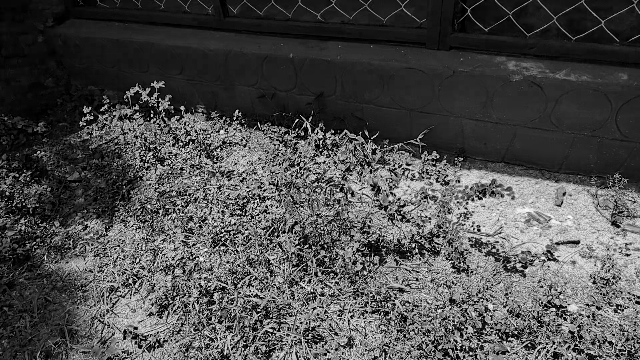

In [ ]:
FULL_IMG =[]

# Read video
video = cv2.VideoCapture("/content/drive/MyDrive/BUTTERFLY/Butterfly_1_long.mp4")
#video = cv2.VideoCapture("/content/drive/MyDrive/BUTTERFLY/Butterfly_2.mp4")
#video =  cv2.VideoCapture("/content/drive/MyDrive/BUTTERFLY/Butterfly_3.mp4")

while True:
  # Read a new frame
  ok, frame = video.read()
  if not ok:
      break
  
  frame = cv2.resize(frame, (frame.shape[1]//3, frame.shape[0]//3))
  FULL_IMG.append(frame)
full_imgs = np.array(FULL_IMG)
print(full_imgs.shape)

del FULL_IMG

print(format_bytes(full_imgs.size))
cv2_imshow(full_imgs[0,...,0])

In [ ]:
full_imgs_0 = full_imgs[...,0] #Taking only the blue channel

del full_imgs #because of memory issues
print(format_bytes(full_imgs_0.size))
print(full_imgs_0.shape)

(333.10546875, 'megabytes')
(1516, 360, 640)


In [ ]:
clrs = ['red', 'green', 'blue', 'white','black','purple','cyan', 'yellow', 'purple',]
remove_green=True
remove_blue=False

diff = 1 #Difference between Frames
print('Difference between frames:',diff)


STRT=700
END= 1900 #adjust based on RAM

kd_cyp = func_kdtree(diff,full_imgs_0[STRT:END],clrs,remove_green=remove_green,remove_blue=remove_blue,
                           REDUCED_COLOR_SPACE = True)

print(kd_cyp.shape)
print(format_bytes(kd_cyp.size))

del full_imgs_0

Difference between frames: 1
(814, 360, 640, 3)
(536.572265625, 'megabytes')


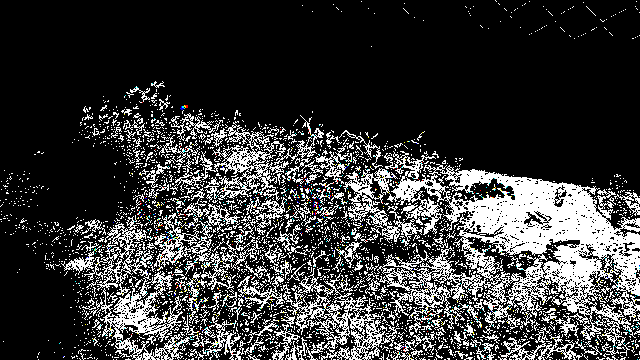

In [ ]:
cv2_imshow(kd_cyp[0]) #First Frame
#Wherever there are colored pixels, those pixels represent motion

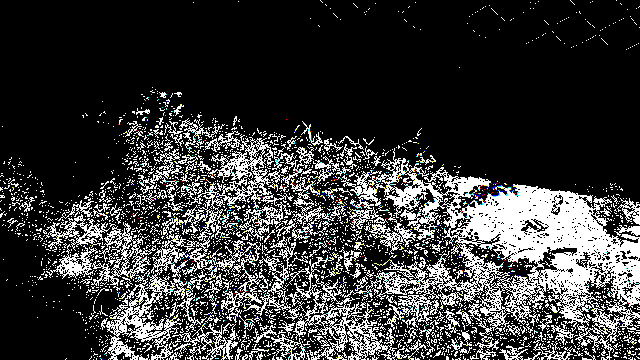

In [ ]:
cv2_imshow(kd_cyp[0]) #First Frame
#Wherever there are colored pixels, those pixels represent motion

(814, 360, 640)
{0: 186860957, 1: 684643}

{0: 187473846, 1: 71754}
{0: 200530, 255: 29870}


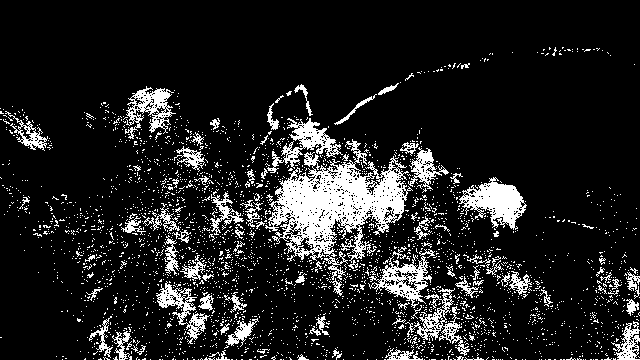

In [ ]:
only_white = np.all(kd_cyp==255,axis=-1)
only_black = np.all(kd_cyp==0,axis=-1)

#XOR
xor_int = np.logical_not(np.logical_xor(only_white,only_black)).astype('uint8')
print(xor_int.shape)
unique, counts = np.unique(xor_int, return_counts=True)
print(dict(zip(unique, counts)))
print()

#DIST_PIXEL=1
pixel_counter=0
for no_frame in range(len(xor_int)):
  single_isolated_pixels_strip_AND(xor_int[no_frame])


unique, counts = np.unique(xor_int, return_counts=True)
print(dict(zip(unique, counts)))

para_xor = np.sum(xor_int==1,axis=0)
fill1 = np.full((para_xor.shape), 0,dtype=int)
#print(fill1.shape)

fill1[para_xor>=1]=255

unique, counts = np.unique(fill1, return_counts=True)
print(dict(zip(unique, counts)))
cv2_imshow(fill1)

(698, 360, 640)
{0: 159973173, 1: 846027}

{0: 160719291, 1: 99909}
{0: 210965, 1: 19435}


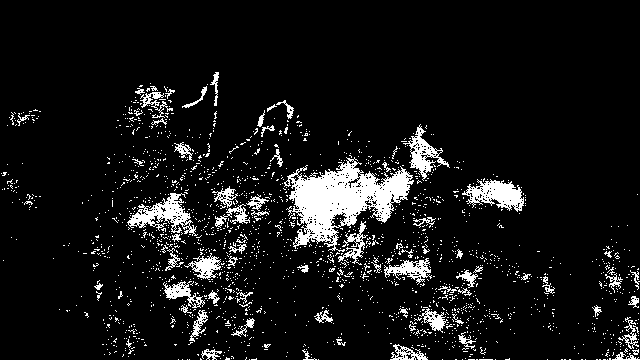

In [ ]:
only_white = np.all(kd_cyp==255,axis=-1)
only_black = np.all(kd_cyp==0,axis=-1)

#XOR
xor_int = np.logical_not(np.logical_xor(only_white,only_black)).astype('uint8')
print(xor_int.shape)
unique, counts = np.unique(xor_int, return_counts=True)
print(dict(zip(unique, counts)))
print()

DIST_PIXEL=1
pixel_counter=0
for no_frame in range(len(xor_int)):
  single_isolated_pixels_strip_AND(xor_int[no_frame])


unique, counts = np.unique(xor_int, return_counts=True)
print(dict(zip(unique, counts)))

para_xor = np.sum(xor_int==1,axis=0)
fill1 = np.full((para_xor.shape), 0,dtype=int)
#print(fill1.shape)

fill1[para_xor<2]=0
fill1[para_xor>=2]=1

unique, counts = np.unique(fill1, return_counts=True)
print(dict(zip(unique, counts)))
cv2_imshow(fill1*255)

{0: 198204, 1: 12761, 2: 6797, 3: 3931, 4: 2428, 5: 1615, 6: 1101, 7: 852, 8: 562, 9: 453, 10: 380, 11: 297, 12: 224, 13: 169, 14: 121, 15: 120, 16: 92, 17: 66, 18: 52, 19: 43, 20: 32, 21: 21, 22: 18, 23: 18, 24: 14, 25: 5, 26: 5, 27: 3, 28: 3, 29: 6, 30: 4, 31: 1, 33: 2}
(360, 640)
(698, 360, 640) 1
{0: 198204, 1: 32196}


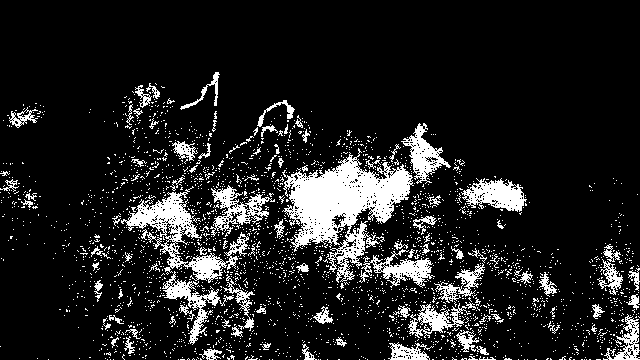

In [ ]:
xor_temp = xor_int.astype(int)
para_xor = np.sum(xor_int==1,axis=0)
fill = np.full((para_xor.shape), 0,dtype=int)
unique, counts = np.unique(para_xor, return_counts=True)
print(dict(zip(unique, counts)))

F=1
fill[para_xor<F]=0
fill[para_xor>=F]=1



single_frame = np.full((para_xor.shape), 0,dtype=int)
print(single_frame.shape)



for n in range(len(xor_temp)):
  xor_temp[n][fill==0]=0
  xor_temp[n] |= single_frame
  single_frame |= xor_temp[n]
  #print(np.sum(single_frame))
print(xor_temp.shape,xor_temp.max())


unique, counts = np.unique(single_frame, return_counts=True)
print(dict(zip(unique, counts)))

#xor_temp[xor_temp>0]=255
cv2_imshow(xor_temp[640]*255)

{0: 210435, 1: 19965}


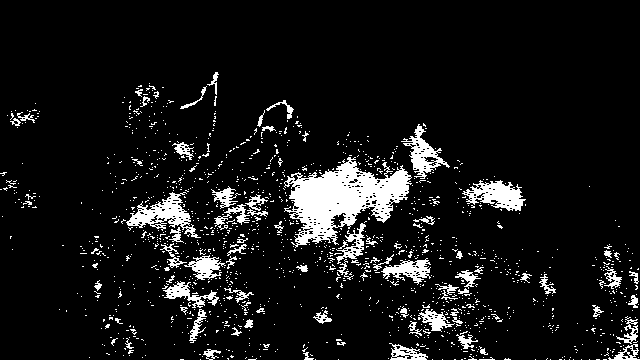

In [ ]:
imgx = single_isolated_pixels_strip_AND(xor_temp[640])
unique, counts = np.unique(imgx, return_counts=True)
print(dict(zip(unique, counts)))
cv2_imshow(imgx*255)

{0: 200530, 1: 13508, 2: 7010, 3: 3606, 4: 2228, 5: 1187, 6: 797, 7: 520, 8: 335, 9: 244, 10: 157, 11: 76, 12: 65, 13: 37, 14: 32, 15: 31, 16: 9, 17: 9, 18: 8, 19: 2, 20: 2, 21: 1, 22: 1, 23: 2, 24: 1, 25: 1, 26: 1}
(360, 640)
(814, 360, 640) 1
{0: 201544, 1: 28856}


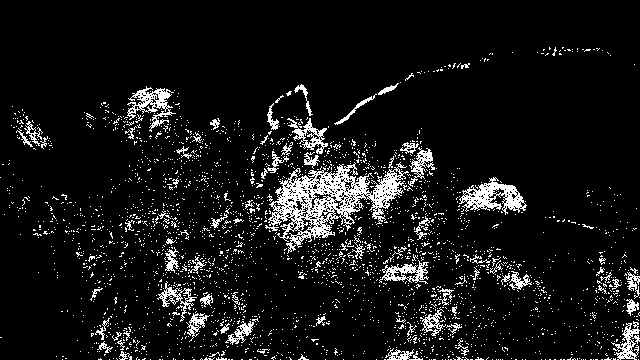

In [ ]:
xor_temp = xor_int.astype(int)
para_xor = np.sum(xor_int==1,axis=0)
fill = np.full((para_xor.shape), 0,dtype=int)
unique, counts = np.unique(para_xor, return_counts=True)
print(dict(zip(unique, counts)))

fill[para_xor<1]=0
#fill[para_xor>=2]=1
fill[(para_xor>=1) & (para_xor<=7)]=1



single_frame = np.full((para_xor.shape), 0,dtype=int)
print(single_frame.shape)



for n in range(len(xor_temp)):
  xor_temp[n][fill==0]=0
  xor_temp[n] |= single_frame
  single_frame |= xor_temp[n]
  #print(np.sum(single_frame))
print(xor_temp.shape,xor_temp.max())

unique, counts = np.unique(single_frame, return_counts=True)
print(dict(zip(unique, counts)))

#xor_temp[xor_temp>0]=255
cv2_imshow(xor_temp[640]*255)

{0: 219948, 1: 10452}


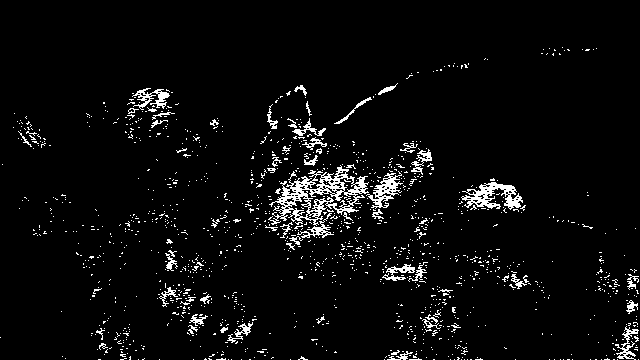

In [ ]:
imgx = single_isolated_pixels_strip_AND(xor_temp[640])
unique, counts = np.unique(imgx, return_counts=True)
print(dict(zip(unique, counts)))
cv2_imshow(imgx*255)

In [ ]:
imgs_700_ = xor_temp.astype('uint8')
print(imgs_700_.shape)
np.save('imgs_700_2.npy',imgs_700_)

(814, 360, 640)


### COMBINE NPY FILES

In [ ]:
def multiple_strip(ST,len_array,N_FRAMES,single_frame1,array):
  MULTIPLE_FRAMES = np.full((1,360,640), 0,dtype=int)

  for start in range(ST,len_array,N_FRAMES):
    if start+N_FRAMES<=(len_array-1):
      pass
    else:
      N_FRAMES= len_array - start 
      #frames = array[start:].astype('int')
      print(start,N_FRAMES,len_array,)
    frames = array[start:(start+N_FRAMES)].astype('int')
 

    single_frame = np.full((360,640), 0,dtype=int)
    mul_frames = np.full((frames.shape), 0,dtype=int)

    for n in range(len(frames)):
      frames[n] |= single_frame
      single_frame |= frames[n]
    strip_frame = single_isolated_pixels_strip_AND(single_frame)
    

    for n1 in range(len(frames)):
      #frames[n1][strip_frame==0]=0
      frames[n1][strip_frame==0]=0
      frames[n1] |= single_frame1
      single_frame1 |= frames[n1]
    
    MULTIPLE_FRAMES = np.concatenate([MULTIPLE_FRAMES,frames]) 
  return MULTIPLE_FRAMES

In [ ]:
#import os, glob
#glob.glob('./*.npy')

In [ ]:
x1 = np.load('/content/imgs_700_1.npy')
x2 = np.load('/content/imgs_700_2.npy')
#x3 = np.load('/content/imgs_700_3.npy')
#x4 = np.load('/content/imgs_700_4.npy')
print(x1.shape,x2.shape,)#x3.shape,x4.shape)
XX = np.concatenate([x1,x2,])#x3,x4])
XX[XX==255]=1
print(XX.shape)
print(format_bytes(XX.size))

(698, 360, 640) (814, 360, 640)
(1512, 360, 640)
(332.2265625, 'megabytes')


1512
1510 2 1512
AFTER:
{0: 168562697, 1: 3950555, 255: 14801948}


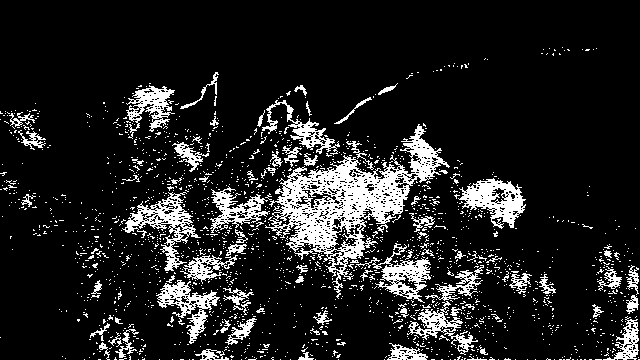

In [ ]:
READ_LAST_FRAME=True

if READ_LAST_FRAME:
  single_frame1 = np.load('/content/imgs_700_1x.npy')[-1].astype('int')
  #single_frame1 = x1[-1].astype('int')
else:
  single_frame1 = np.full((360,640), 0,dtype=int)


N_FRAMES=10
ST=700
END = 1800
len_xx = len(XX[:END])
print(len_xx)

MUL_FRAMES = multiple_strip(ST,len_xx,N_FRAMES,single_frame1,XX)
#print(MUL_FRAMES.shape)
print('AFTER:')
unique, counts = np.unique(MUL_FRAMES, return_counts=True)
print(dict(zip(unique, counts)))
#cv2_imshow([500]*255)
MUL_FRAMES[MUL_FRAMES>0]=255
cv2_imshow(MUL_FRAMES[-1])

(813, 360, 640)


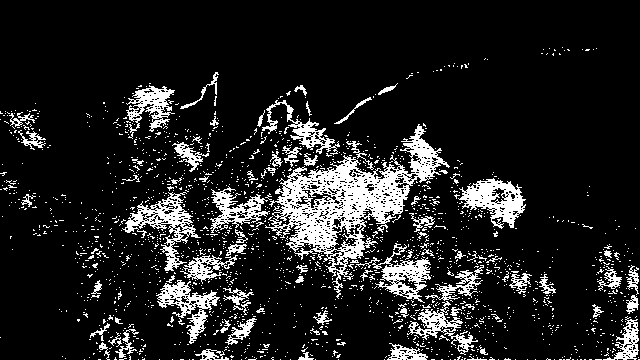

In [ ]:
imgs_700_x = MUL_FRAMES.astype('uint8')
print(imgs_700_x .shape)
np.save('imgs_700_2x.npy',imgs_700_x )
cv2_imshow(imgs_700_x[-1])

In [ ]:
#imgs3_1500_2 = MULTIPLE_FRAMES.astype('uint8')
#print(imgs3_1500_2.shape)
#np.save('./imgs3_1500_2.npy',imgs3_1500_2)
x1 = np.load('/content/imgs_700_1x.npy')
x2 = np.load('/content/imgs_700_2x.npy')
x3 = np.load('/content/imgs_700_3x.npy')
x4 = np.load('/content/imgs_700_4x.npy')
print(x1.shape,x2.shape)

MULTIPLE_FRAMES = np.concatenate([x1,x2,x3,x4],)
print(MULTIPLE_FRAMES.shape)
print(format_bytes(MULTIPLE_FRAMES.size))

(701, 360, 640) (701, 360, 640)
(2740, 360, 640)
(602.05078125, 'megabytes')


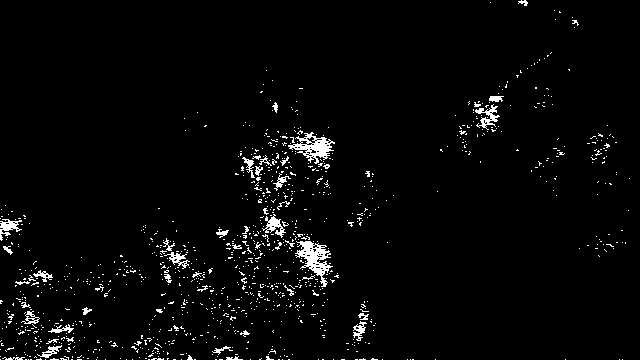

In [ ]:
cv2_imshow(MULTIPLE_FRAMES[-1])

In [ ]:
#diff=1
#Create GIFS
#imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
#imgs = np.array(XOR_IMG).astype('uint8')
#imgs = MULTIPLE_FRAMES.astype('uint8')
#images = xor_int
#imgs = [Image.fromarray(img) for img in imgs ]
# duration is the number of milliseconds between frames; this is 40 frames per second
#imgs[0].save(f'DIFF{diff}butterfly_3_full.gif', save_all=True, append_images=imgs[1:], duration=1, loop=0)

In [ ]:
diff=1
imgs = MULTIPLE_FRAMES.astype('uint8')
#imageio.mimsave('./butterfly_3_imageio2.gif', imgs,duration = 0.004)
imageio.mimsave('./butterfly_3_imageio_60_2.mp4', imgs,fps=60)